In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/custom_data/'
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd
ori_export = pd.read_csv(path+'exports.csv')
ori_umcsent = pd.read_csv(path+'UMCSENT.csv', skiprows= 10 ,dtype = {'observation_date':str,'UMCSENT':float})
ori_epu = pd.read_csv(path+'EPU.csv')

In [ ]:
for i in ori_export.columns:
  if i != '기간':
    ori_export[i] = pd.to_numeric(ori_export[i].str.replace(pat=r'[^A-Za-z0-9]', repl= '', regex=True),downcast='float')

In [ ]:
f1 = ori_epu['Three_Component_Index'][180:430]
f1.index = np.arange(0,250)
trn_y = ori_export['수출금액'][1:251]
trn_y.index = np.arange(0,250)
DATA = pd.concat([ori_umcsent['UMCSENT'][:250],f1,trn_y],axis=1,ignore_index=True)
DATA.index = ori_export['기간'][1:251]

In [ ]:
def scaling(x):
  min_max_scaler = MinMaxScaler()
  df = x.copy()
  fitted = min_max_scaler.fit(x)
  output = min_max_scaler.transform(x)
  output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))
  return output

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X = scaling(DATA)
X.describe()

,0,1,2
count,250.000000,250.000000,250.000000
mean,0.534998,0.215624,0.526546
std,0.215383,0.152158,0.294877
min,0.000000,0.000000,0.000000
25%,0.369489,0.111933,0.273633
50%,0.582892,0.179071,0.603650
75%,0.694885,0.284004,0.792516
max,1.000000,1.000000,1.000000


In [ ]:
DNN = np.loadtxt(path+'DNN_0710.txt', delimiter=',')
LSTM = np.loadtxt(path+'LSTM.txt', delimiter=',')
GRU = np.loadtxt(path+'GRU.txt', delimiter=',')

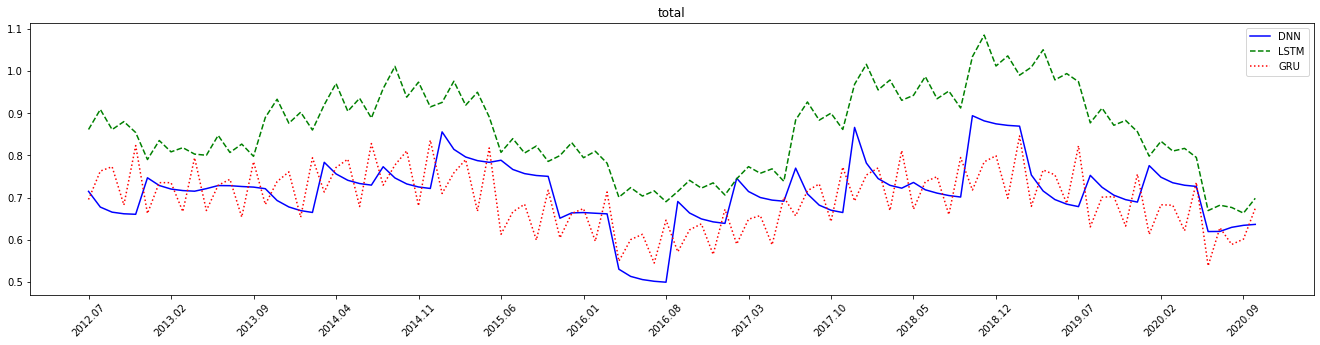

In [ ]:
import matplotlib.ticker as ticker
days = DATA.index.values[-100:]
plt.figure(figsize=(23,5))
plt.title('total')
plt.plot(days,DNN,'b-',label='DNN')
plt.plot(days,LSTM,'g--',label='LSTM')
plt.plot(days,GRU,'r:',label='GRU')
plt.xticks(rotation=45)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.legend()
plt.show()

In [ ]:
from scipy.stats import t
ensemble = np.concatenate((DNN.reshape(-1,100),LSTM.reshape(-1,100),GRU.reshape(-1,100)),axis=0)
ensemble_mean = ensemble.mean(axis=0)
ensemble_std = ensemble.std(axis=0)
tree_n =3
df = tree_n-1
t_ = t(df)
t_05 = t_.ppf(0.95)
L_= ensemble_mean - t_05*(ensemble_std/np.sqrt(tree_n))
U_= ensemble_mean + t_05*(ensemble_std/np.sqrt(tree_n))

df = tree_n-1
t_ = t(df)
t_10 = t_.ppf(0.90)
L__= ensemble_mean - t_05*(ensemble_std/np.sqrt(tree_n))
U__= ensemble_mean + t_05*(ensemble_std/np.sqrt(tree_n))

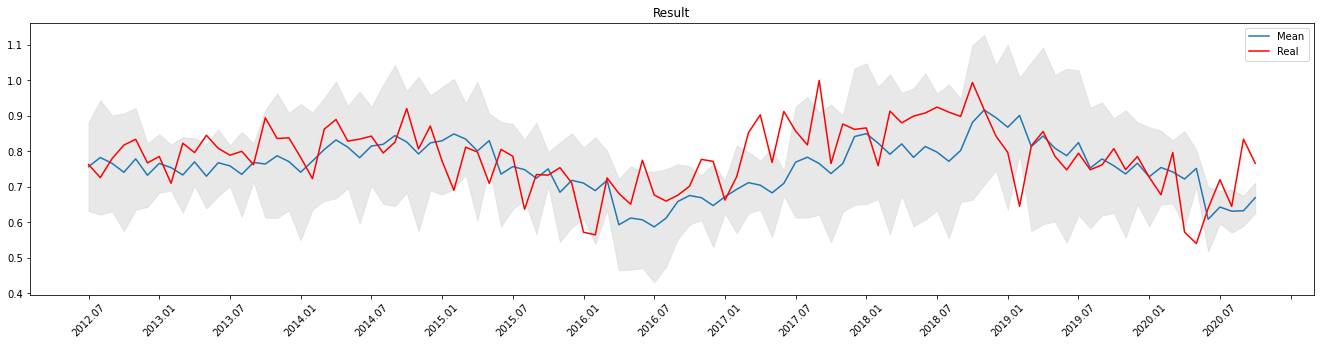

In [ ]:
L = L_.copy()
U = U_.copy()
L2 = L__.copy()
U2 = U__.copy()

MU = ensemble_mean.copy()

days = DATA.index.values[-100:]
asw_y = X[2].values[-100:]
plt.figure(figsize=(23,5))
plt.plot(days,MU,label='Mean')
plt.plot(days,asw_y,'r-',label='Real')
plt.title('Result')
plt.fill_between(days, L, U, color='lightgray', alpha=0.5)
#plt.fill_between(days, L2, U2, color='lightgray', alpha=0.5)
plt.xticks(rotation=45)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
plt.legend()
plt.show()

In [ ]:
np.savetxt(path+'ESB_L.txt', L, fmt='%.6f', delimiter=',')
np.savetxt(path+'ESB_U.txt', U, fmt='%.6f', delimiter=',')
np.savetxt(path+'ESB_MU.txt', MU, fmt='%.6f', delimiter=',')

In [ ]:
VAL_L = np.loadtxt(path+'VAR_L.txt', delimiter=',')
VAL_MU = np.loadtxt(path+'VAR_MU.txt', delimiter=',')
VAL_U = np.loadtxt(path+'VAR_U.txt', delimiter=',')

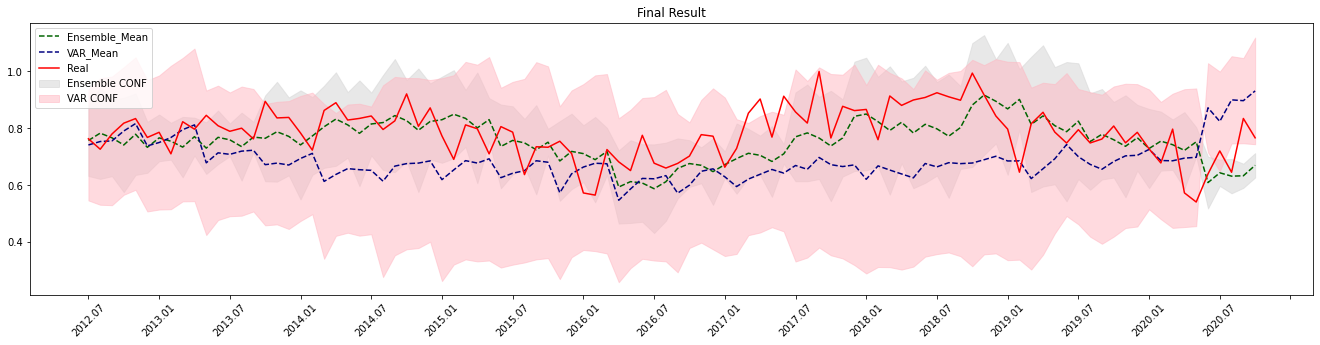

In [ ]:
ESB_L = L_.copy()
ESB_U = U_.copy()
L2 = L__.copy()
U2 = U__.copy()

V_L = VAL_L.copy()
V_U= VAL_U.copy()
V_MU = VAL_MU.copy()


ESB_MU = ensemble_mean.copy()

days = DATA.index.values[-100:]
asw_y = X[2].values[-100:]
plt.figure(figsize=(23,5))
plt.plot(days,ESB_MU,label='Ensemble_Mean',color='darkgreen',linestyle='--')
plt.plot(days,V_MU,label='VAR_Mean',color='navy',linestyle='--')

plt.plot(days,asw_y,label='Real',color='red',linestyle='-')
plt.title('Final Result')
plt.fill_between(days, ESB_L, ESB_U, color='lightgray', alpha=0.5,label='Ensemble CONF')
plt.fill_between(days, V_L, V_U, color='lightpink', alpha=0.5,label='VAR CONF')
#plt.fill_between(days, L2, U2, color='lightgray', alpha=0.5)
plt.xticks(rotation=45)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
plt.legend()
plt.show()

In [ ]:
var2real = np.sqrt((V_MU - asw_y)**2).mean()
ensemble2real =np.sqrt(( ESB_MU - asw_y )**2).mean()
print('var loss : ',var2real)
print('ensemble loss : ',ensemble2real)

var loss :  0.12974336040822457
ensemble loss :  0.06723749293389425


In [ ]:
Conf_VAR = V_U - V_L
Conf_ESB = ESB_U - ESB_L
print('var CONFIDENCE : ',Conf_VAR.mean())
print('ensemble CONFIDENCE : ',Conf_ESB.mean())

var CONFIDENCE :  0.5123895099999999
ensemble CONFIDENCE :  0.2716851847916147
